**1. Import all neccessery libraries**

In [83]:
from google.cloud import bigquery
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import json

**2. Get data**

    2.1 From GoogleCloud and create a Data Frame 'df_query'

NOTE:

    'new_crypto_ethereum_sample20k_new_wallets_2023' was previously created with SQL-queries on BigQuery.
    All queries are saved in query_ethereum_project.txt

key_file_path = "my-project-444222-1be5aecf7dbb.json"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_file_path

In [40]:
client = bigquery.Client()

query = """
SELECT *
FROM `my-project-444222.wallets_2023.new_crypto_ethereum_sample20k_new_wallets_2023`
"""
df_query = client.query(query).to_dataframe()

In [41]:
df_query.head(5)

,from_address,first_transaction_time,to_address,gas,gas_price,hash,transaction_type,receipt_gas_used,value
0,0x560d6afd57691c9d73728214d7287f7ba495bfb1,2023-04-13 02:17:59+00:00,0xf48b45479ba7e121a3542626d5a5f3b07ec5b65d,197376,40731401487,0x5deb9d2adf75d687cfc95895f5fdda0c0d6ccbb37620...,2,131584,500000000000000000.000000000
1,0x67c35bea48140d64922aac45fab68f5f7ab30263,2023-09-12 14:03:23+00:00,0x3a23f943181408eac424116af7b7790c94cb97a5,67840,26186170128,0x1e4fd147875750578c15608b56775fc31add5cf16cf8...,2,67786,5300000000000000.000000000
2,0xb05490b8e0a65f14ef11245094fa847217999df9,2023-07-15 10:14:11+00:00,0x92853a460a0f25fcbea51c02c4ae167cc0a5ccc4,137216,12625542978,0x5d6ad02f3f6444089cf9750c962f18f0b53a5aa9673a...,2,133313,0E-9
3,0x8b613b54725d4ac4dd29876d7d1e7ac19079aa60,2023-08-17 10:22:59+00:00,0xb2089a7069861c8d90c8da3aacab8e9188c0c531,77568,15535760611,0x184f06f7f119660590cc52389f28b6dab98f179eb1cd...,2,51712,0E-9
4,0x740325f3ad2f2eb22ac46f70b5614ada96a0d574,2023-02-15 09:53:47+00:00,0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce,77824,24192656923,0xc139b7ff06211765c560e03e7556eb8cd308dbc2d116...,2,51883,0E-9


In [42]:
df_query.to_csv('bigquery_ethereum_sample20k.csv')

    2.2 With api.etherscan and create Data Frame 'df_api'.
    
    When 'from_address' is known, it is possible to get all informations about address
    with api.etherscan.

In [80]:
etherscan_api_key = "MY_API_KEY"

address = df_query['from_address'].tolist()

In [56]:
def get_api_json(addresses):
    """
    Fetch the first transaction for a list of Ethereum addresses using the Etherscan API.

    This function iterates over a list of Ethereum addresses, sends API requests to fetch 
    their transaction history, and saves only the first transaction (by timestamp) for each 
    address into a CSV file. If an address has no transactions, it logs this information 
    into the CSV file. If an API request fails, the error is logged in a separate log file.

    Args:
        addresses (list): A list of Ethereum addresses as strings.

    Returns:
        None: The function writes data to a CSV file and logs errors if any.

    Notes:
        - Only the first transaction (sorted by `timeStamp`) for each address is saved in 
          '20k_first_transactions.csv'.
        - If an address has no transactions, a row with `{'address': address, 'transactions': 0}` 
          is added to the CSV.
        - Failed responses are logged in 'api_errors.log'.
        - Ensure that the API key (`etherscan_api_key`) is correctly configured.

    Raises:
        None: The function handles errors by logging them to 'api_errors.log'.
    """
    for address in addresses:
        response = requests.get(
            f"https://api.etherscan.io/api?module=account&action=txlist"
            f"&address={address}&startblock=0&endblock=99999999&sort=asc"
            f"&apikey={etherscan_api_key}"
        ) 
        if response.status_code == 200 and response.json()['status'] == '1':
            transactions = response.json()['result']
            if transactions:
                first_transaction = transactions[0]
                transactions_df = pd.DataFrame([first_transaction])
                transactions_df.to_csv(
                    '20k_first_transactions.csv',
                    mode='a',
                    header=not os.path.exists('got_from_api_first_transactions.csv'),
                    index=False
                )
            else:
                pd.DataFrame(
                    [{'address': address, 'transactions': 0}]
                ).to_csv(
                    'got_from_api_first_transactions.csv',
                    mode='a',
                    header=False,
                    index=False
                )
        else:
            with open('api_errors.log', 'a') as log_file:
                log_file.write(
                    f"Failed response for address: {address}, "
                    f"status: {response.json().get('status')}\n"
                )


In [48]:
def rate_limited_function(func, *args):
    """
    Wrap a function to limit the number of calls to comply with API rate limits.

    This decorator ensures that the decorated function respects a limit of 
    five calls per second by adding a delay when the limit is reached.

    Args:
        func (callable): The function to be rate-limited. It should accept 
        arguments passed by the caller of the wrapped function.

    Returns:
        callable: A wrapped version of the input function that enforces 
        the rate limit.

    Notes:
        - The delay is introduced using `time.sleep()` when the number of 
          calls reaches the limit within a one-second window.
        - This implementation uses a nonlocal counter (`request_count`) 
          and a timestamp (`start_time`) to track the number of calls and 
          elapsed time.

    Example:
        ```
        def fetch_data(param):
            # Your function logic here
            pass
        
        rate_limited_fetch_data = rate_limited_function(fetch_data)
        rate_limited_fetch_data(arg1, arg2)
        ```
    """
    request_count = 0
    start_time = time.time()

    def wrapper(*args):
        nonlocal request_count, start_time
        
        result = func(*args)
        
        request_count =+ 1
        if request_count == 5:
            elapsed_time = time.time() - start_time
            if elapsed_time < 1:
                time.sleep(1 - elapsed_time)
            request_count = 0
            start_time = time.time()
            
        return result 

    return wrapper

In [49]:
rate_limited_get_api_json = rate_limited_function(get_api_json)
rate_limited_get_api_json(address)

In [54]:
df_api = pd.read_csv('got_from_api_first_transactions.csv') 

In [55]:
df_api.head(5)

,blockNumber,blockHash,timeStamp,hash,nonce,transactionIndex,from,to,value,gas,gasPrice,input,methodId,functionName,contractAddress,cumulativeGasUsed,txreceipt_status,gasUsed,confirmations,isError
0,17035845,0xf84c428f5ed89e29757242486b2957da4b6a3c3a6e3f...,1681352279,0x5deb9d2adf75d687cfc95895f5fdda0c0d6ccbb37620...,0,48,0x560d6afd57691c9d73728214d7287f7ba495bfb1,0xf48b45479ba7e121a3542626d5a5f3b07ec5b65d,500000000000000000,197376,40731401487,0xba41b0c6000000000000000000000000000000000000...,0xba41b0c6,"mint(uint256 inAmount, bytes32[] merkleProof)",NaN,4277588,1.0,131584,4439701,0
1,18120578,1694525675,0x4a44edd542126d316e77818d57efee097dd123125f4e...,4,0xd28e9014af3ec057d1832d6ebec077adcb2341e9c0ed...,157,0x862d5e6bd23948062f6db450015a33c1f2594a6b,0x67c35bea48140d64922aac45fab68f5f7ab30263,18140823025860190,21000,23034940343,0,1,0x,NaN,13638466,21000.0,3354969,0x,NaN
2,17693093,0xb812f2de16131b2b7beb907f2f3b7a990d5b889bf9ad...,1689354659,0x5bba8aeb4621b62ebfbb2cc986a40fe7b540d8240668...,1188513,32,0xa7efae728d2936e78bda97dc267687568dd593f3,0xb05490b8e0a65f14ef11245094fa847217999df9,33714000000000000,210000,49339994961,0x,0x,NaN,NaN,4077094,1.0,21000,3782455,0
3,17931606,0x2c6e5b3bbb544cdb9c5e3ee292ecffabd2911c918b07...,1692239831,0xa7650fb970a3c640f95011922486ee8ac8ce86ad534e...,64,120,0xc661a914110a7b9c745e0da352bf79627f88efbe,0x8b613b54725d4ac4dd29876d7d1e7ac19079aa60,1500000000000000,21000,22378654725,0x,0x,NaN,NaN,12520353,1.0,21000,3543942,0
4,16633362,0x8eed2605e1168c11224468667ed1cb7378a241992cc1...,1676454659,0x4943ce8316acc275cd1105a86dcf90dc581b810a28c6...,190852,21,0x8d56f551b44a6da6072a9608d63d664ce67681a5,0x740325f3ad2f2eb22ac46f70b5614ada96a0d574,8666620000000000,50000,27468989502,0x,0x,NaN,NaN,1064344,1.0,21000,4842186,0




It's interesting to understand the difference between the tables. The 'address' list was selected from BigQuery, and the table 'new_crypto_ethereum_sample20k_new_wallets_2023' contains the first outgoing transactions of new wallets (address), meaning the from_address.

Meanwhile, the table obtained through API filtering for 'address' includes the first transactions where the 'address' is in the 'to' field, meaning these are their incoming transactions.



**Because the API returned JSON with varying key sequences, some data was unpacked incorrectly into the table. Let's fix this:**

In [60]:
def fix_row(row):
    """
    Fixes row values based on the length of the 'timeStamp' column.
    If 'timeStamp' length is greater than 10, reassign the values as per the given logic.
    """
    if len(str(row['timeStamp'])) > 10:
        temp_blockHash = row['blockHash']
        temp_nonce = row['nonce']
        temp_hash = row['hash']
        temp_timestamp = row['timeStamp']

        row['blockHash'] = temp_nonce
        row['timeStamp'] = temp_blockHash
        row['hash'] = temp_timestamp
        row['nonce'] = temp_hash
    return row

In [63]:
df_api = df_api.apply(fix_row, axis=1)

In [66]:
df_api.head(5)

,blockNumber,blockHash,timeStamp,hash,nonce,transactionIndex,from,to,value,gas,gasPrice,input,methodId,functionName,contractAddress,cumulativeGasUsed,txreceipt_status,gasUsed,confirmations,isError
0,17035845,0xf84c428f5ed89e29757242486b2957da4b6a3c3a6e3f...,1681352279,0x5deb9d2adf75d687cfc95895f5fdda0c0d6ccbb37620...,0,48,0x560d6afd57691c9d73728214d7287f7ba495bfb1,0xf48b45479ba7e121a3542626d5a5f3b07ec5b65d,500000000000000000,197376,40731401487,0xba41b0c6000000000000000000000000000000000000...,0xba41b0c6,"mint(uint256 inAmount, bytes32[] merkleProof)",NaN,4277588,1.0,131584,4439701,0
1,18120578,0xd28e9014af3ec057d1832d6ebec077adcb2341e9c0ed...,1694525675,0x4a44edd542126d316e77818d57efee097dd123125f4e...,4,157,0x862d5e6bd23948062f6db450015a33c1f2594a6b,0x67c35bea48140d64922aac45fab68f5f7ab30263,18140823025860190,21000,23034940343,0,1,0x,NaN,13638466,21000.0,3354969,0x,NaN
2,17693093,0xb812f2de16131b2b7beb907f2f3b7a990d5b889bf9ad...,1689354659,0x5bba8aeb4621b62ebfbb2cc986a40fe7b540d8240668...,1188513,32,0xa7efae728d2936e78bda97dc267687568dd593f3,0xb05490b8e0a65f14ef11245094fa847217999df9,33714000000000000,210000,49339994961,0x,0x,NaN,NaN,4077094,1.0,21000,3782455,0
3,17931606,0x2c6e5b3bbb544cdb9c5e3ee292ecffabd2911c918b07...,1692239831,0xa7650fb970a3c640f95011922486ee8ac8ce86ad534e...,64,120,0xc661a914110a7b9c745e0da352bf79627f88efbe,0x8b613b54725d4ac4dd29876d7d1e7ac19079aa60,1500000000000000,21000,22378654725,0x,0x,NaN,NaN,12520353,1.0,21000,3543942,0
4,16633362,0x8eed2605e1168c11224468667ed1cb7378a241992cc1...,1676454659,0x4943ce8316acc275cd1105a86dcf90dc581b810a28c6...,190852,21,0x8d56f551b44a6da6072a9608d63d664ce67681a5,0x740325f3ad2f2eb22ac46f70b5614ada96a0d574,8666620000000000,50000,27468989502,0x,0x,NaN,NaN,1064344,1.0,21000,4842186,0


Сhecking if everything has been fixed:

In [68]:
print(df_api[df_api['timeStamp'].apply(lambda x: len(str(x)) > 10)])

Empty DataFrame
Columns: [blockNumber, blockHash, timeStamp, hash, nonce, transactionIndex, from, to, value, gas, gasPrice, input, methodId, functionName, contractAddress, cumulativeGasUsed, txreceipt_status, gasUsed, confirmations, isError]
Index: []


**Converting the timestamp column into a readable format:**

In [78]:
df_api['timeStamp'] = pd.to_numeric(df_api['timeStamp'], errors='coerce')
df_api['timeStamp'] = df_api['timeStamp'].apply(lambda x: x / 1e9 if x > 1e10 else x)
df_api['timeStamp'] = pd.to_datetime(df_api['timeStamp'], unit='s', errors='coerce')

In [77]:
df_api.head(5)

,blockNumber,blockHash,timeStamp,hash,nonce,transactionIndex,from,to,value,gas,gasPrice,input,methodId,functionName,contractAddress,cumulativeGasUsed,txreceipt_status,gasUsed,confirmations,isError
0,17035845,0xf84c428f5ed89e29757242486b2957da4b6a3c3a6e3f...,2023-04-13 02:17:59,0x5deb9d2adf75d687cfc95895f5fdda0c0d6ccbb37620...,0,48,0x560d6afd57691c9d73728214d7287f7ba495bfb1,0xf48b45479ba7e121a3542626d5a5f3b07ec5b65d,500000000000000000,197376,40731401487,0xba41b0c6000000000000000000000000000000000000...,0xba41b0c6,"mint(uint256 inAmount, bytes32[] merkleProof)",NaN,4277588,1.0,131584,4439701,0
1,18120578,0xd28e9014af3ec057d1832d6ebec077adcb2341e9c0ed...,2023-09-12 13:34:35,0x4a44edd542126d316e77818d57efee097dd123125f4e...,4,157,0x862d5e6bd23948062f6db450015a33c1f2594a6b,0x67c35bea48140d64922aac45fab68f5f7ab30263,18140823025860190,21000,23034940343,0,1,0x,NaN,13638466,21000.0,3354969,0x,NaN
2,17693093,0xb812f2de16131b2b7beb907f2f3b7a990d5b889bf9ad...,2023-07-14 17:10:59,0x5bba8aeb4621b62ebfbb2cc986a40fe7b540d8240668...,1188513,32,0xa7efae728d2936e78bda97dc267687568dd593f3,0xb05490b8e0a65f14ef11245094fa847217999df9,33714000000000000,210000,49339994961,0x,0x,NaN,NaN,4077094,1.0,21000,3782455,0
3,17931606,0x2c6e5b3bbb544cdb9c5e3ee292ecffabd2911c918b07...,2023-08-17 02:37:11,0xa7650fb970a3c640f95011922486ee8ac8ce86ad534e...,64,120,0xc661a914110a7b9c745e0da352bf79627f88efbe,0x8b613b54725d4ac4dd29876d7d1e7ac19079aa60,1500000000000000,21000,22378654725,0x,0x,NaN,NaN,12520353,1.0,21000,3543942,0
4,16633362,0x8eed2605e1168c11224468667ed1cb7378a241992cc1...,2023-02-15 09:50:59,0x4943ce8316acc275cd1105a86dcf90dc581b810a28c6...,190852,21,0x8d56f551b44a6da6072a9608d63d664ce67681a5,0x740325f3ad2f2eb22ac46f70b5614ada96a0d574,8666620000000000,50000,27468989502,0x,0x,NaN,NaN,1064344,1.0,21000,4842186,0


**3. Categorising transactions on "Outgoing" and "Incoming"**

In [81]:
df_api["trans_direction"] = "Unknown"
df_api.loc[df_api["from"].isin(address), "trans_direction"] = "Outgoing"
df_api.loc[df_api["to"].isin(address), "trans_direction"] = "Incoming"

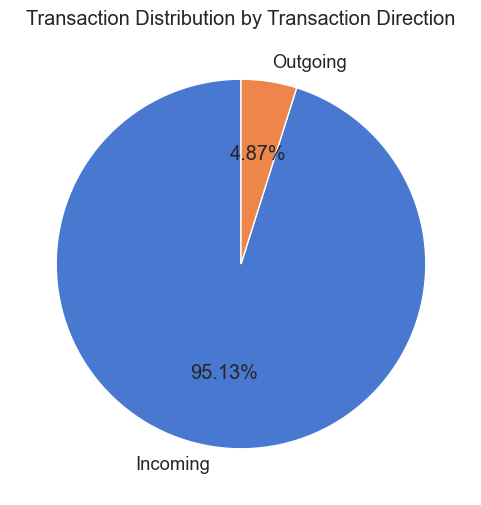

In [82]:
transaction_counts = df_api["trans_direction"].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 6))
transaction_counts.plot(kind="pie", autopct="%.2f%%", startangle=90, labels=transaction_counts.index)
plt.title("Transaction Distribution by Transaction Direction")
plt.ylabel("")
plt.show()

It turns out that 95.13% of the first transactions made by newcomers are incoming transactions.

**4. Categorising transactions by their type**

In [84]:
function_categories = {
    'transfer': 'Token Transfer',
    'approve': 'Token Approval',
    'mint': 'Token Minting',
    'burn': 'Token Burning',
    'swap': 'Token Swap',
    'execute': 'Contract Execution',
    'bridge': 'Cross-Chain Bridge',
    'init': 'Initialization'
}


def categorize_transaction(function_name):
    if not isinstance(function_name, str):
        return 'Unknown'
    for keyword, category in function_categories.items():
        if keyword in function_name:
            return category
    return 'Unknown'


def categorize_row(row):
    if row['input'] == '0x' and int(row['value']) > 0:
        return 'ETH transfer'
    elif (row['input'] != '0x' and row['methodId'] != '0x'):
        return categorize_transaction(row['functionName'])
    else:
        return 'Unknown'


In [85]:
df_api['transaction_type'] = df_api.apply(categorize_row, axis=1)

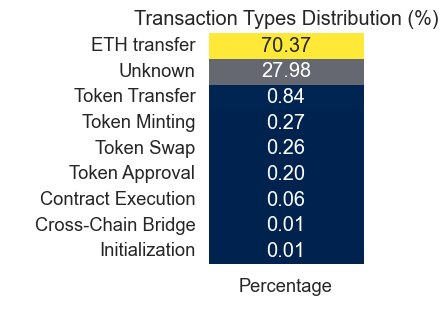

In [86]:
import seaborn as sns

transaction_type_counts = df_api['transaction_type'].value_counts(normalize=True) * 100
transaction_type_counts = transaction_type_counts.sort_values(ascending=False)

transaction_df = pd.DataFrame(transaction_type_counts).reset_index()
transaction_df.columns = ['Transaction Type', 'Percentage']

plt.figure(figsize=(2, 3))
sns.heatmap(transaction_df.set_index('Transaction Type'), annot=True, fmt='.2f', cmap='cividis', cbar=False)
plt.title('Transaction Types Distribution (%)')
plt.xlabel(' ')
plt.ylabel(' ');

***Unknown transactions require additional analysis. It is likely that function_categories needs to be expanded.***

**5. Transactions by months, using df_query from BigQuery because of ready UTC date format**

* Transforming date from api also is possible

In [89]:
transactions_per_month = df_api.groupby(df_api.timeStamp.dt.month)['from'].count().reset_index()
transactions_per_month = transactions_per_month.sort_values(by='timeStamp')

In [90]:
import calendar
transactions_per_month['timeStamp'] = transactions_per_month['timeStamp'].apply(lambda x: calendar.month_abbr[x])

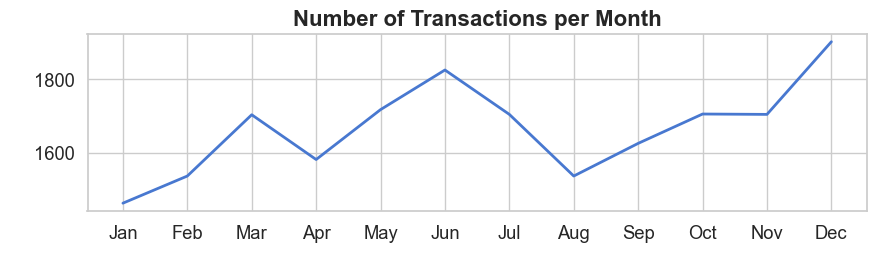

In [91]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(9, 3))
sns.lineplot(
    data=transactions_per_month,
    x='timeStamp',
    y='from',
    linewidth=2
)

plt.title('Number of Transactions per Month', fontsize=16, fontweight='bold')
plt.xlabel(' ', fontsize=14)
plt.ylabel(' ', fontsize=14)

plt.tight_layout()
plt.show()

The graph showing the number of new wallets suggests a certain seasonality in their activity.

**6. Categories by Transaction Amounts:**


    - "Zero": Transactions with 0 (e.g., = 0.0 ETH)
    - "Micro": Transactions with very small amounts (e.g., < 0.001 ETH).
    - "Small": Transactions with small amounts (e.g., 0.001 to 0.1 ETH).
    - "Medium": Transactions with medium amounts (e.g., 0.1 to 1 ETH).
    - "Large": Transactions with large amounts (e.g., 1 to 10 ETH).
    - "Whale": Transactions with very large amounts (e.g., > 10 ETH).

In [92]:
df_api['value'] = df_api['value'].apply(float)
df_api['eth_value'] = df_api['value'] / 1e18

In [93]:
df_api['value_category'] = 'Zero'

bins = [0, 0.001, 0.01, 0.1, 1, 10, float('inf')]
labels = ['Micro', 'Small', 'Medium', 'Large', 'Whale', 'Mega Whale']

df_api.loc[df_api['eth_value'] > 0, 'value_category'] = pd.cut(
    df_api['eth_value'], bins=bins, labels=labels
)

print(df_api['value_category'].value_counts(normalize=True) * 100)

value_category
Medium        41.520
Small         25.895
Large         19.965
Whale          5.525
Micro          3.930
Zero           2.090
Mega Whale     1.075
Name: proportion, dtype: float64


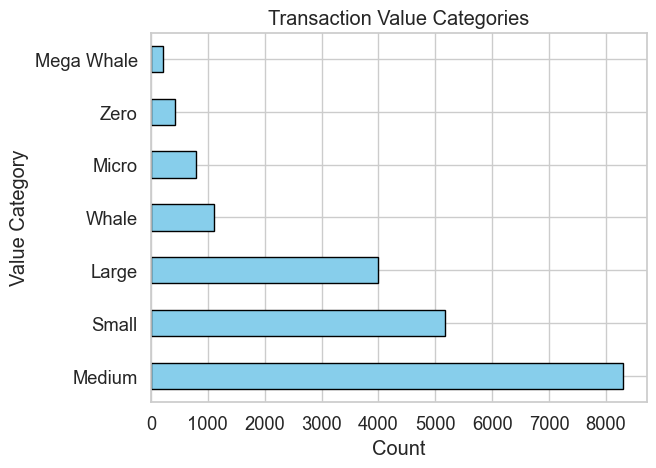

In [94]:
df_api['value_category'].value_counts().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Transaction Value Categories')
plt.xlabel('Count')
plt.ylabel('Value Category')
plt.show()


**7. Сheck if there is a relationship between zero-value transactions and smart contracts**

In [96]:
df_api['value'] = df_api['value'].apply(float)
df_api['eth_value'] = df_api['value'] / 1e18

In [97]:
df_api.head(5)

,blockNumber,blockHash,timeStamp,hash,nonce,transactionIndex,from,to,value,gas,...,contractAddress,cumulativeGasUsed,txreceipt_status,gasUsed,confirmations,isError,trans_direction,transaction_type,eth_value,value_category
0,17035845,0xf84c428f5ed89e29757242486b2957da4b6a3c3a6e3f...,2023-04-13 02:17:59,0x5deb9d2adf75d687cfc95895f5fdda0c0d6ccbb37620...,0,48,0x560d6afd57691c9d73728214d7287f7ba495bfb1,0xf48b45479ba7e121a3542626d5a5f3b07ec5b65d,5.000000e+17,197376,...,NaN,4277588,1.0,131584,4439701,0,Outgoing,Token Minting,0.5000,Large
1,18120578,0xd28e9014af3ec057d1832d6ebec077adcb2341e9c0ed...,2023-09-12 13:34:35,0x4a44edd542126d316e77818d57efee097dd123125f4e...,4,157,0x862d5e6bd23948062f6db450015a33c1f2594a6b,0x67c35bea48140d64922aac45fab68f5f7ab30263,5.300000e+15,21000,...,NaN,13638466,21000.0,3354969,0x,NaN,Incoming,Unknown,0.0053,Medium
2,17693093,0xb812f2de16131b2b7beb907f2f3b7a990d5b889bf9ad...,2023-07-14 17:10:59,0x5bba8aeb4621b62ebfbb2cc986a40fe7b540d8240668...,1188513,32,0xa7efae728d2936e78bda97dc267687568dd593f3,0xb05490b8e0a65f14ef11245094fa847217999df9,0.000000e+00,210000,...,NaN,4077094,1.0,21000,3782455,0,Incoming,ETH transfer,0.0000,Medium
3,17931606,0x2c6e5b3bbb544cdb9c5e3ee292ecffabd2911c918b07...,2023-08-17 02:37:11,0xa7650fb970a3c640f95011922486ee8ac8ce86ad534e...,64,120,0xc661a914110a7b9c745e0da352bf79627f88efbe,0x8b613b54725d4ac4dd29876d7d1e7ac19079aa60,0.000000e+00,21000,...,NaN,12520353,1.0,21000,3543942,0,Incoming,ETH transfer,0.0000,Small
4,16633362,0x8eed2605e1168c11224468667ed1cb7378a241992cc1...,2023-02-15 09:50:59,0x4943ce8316acc275cd1105a86dcf90dc581b810a28c6...,190852,21,0x8d56f551b44a6da6072a9608d63d664ce67681a5,0x740325f3ad2f2eb22ac46f70b5614ada96a0d574,0.000000e+00,50000,...,NaN,1064344,1.0,21000,4842186,0,Incoming,ETH transfer,0.0000,Small


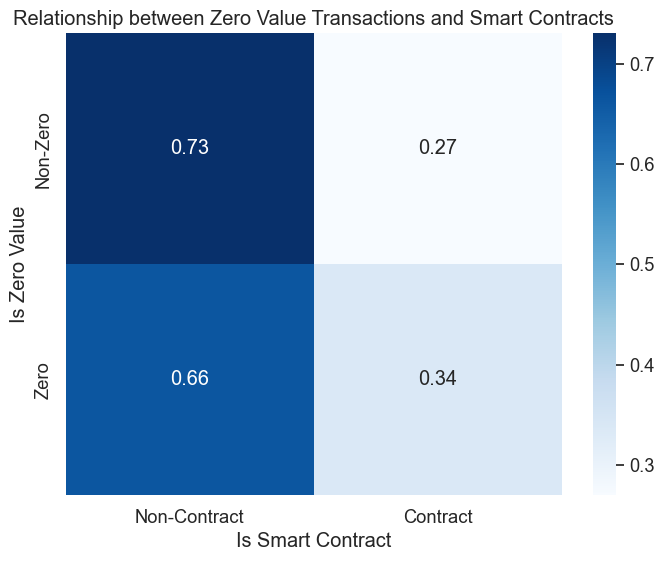

In [98]:
import seaborn as sns

df_api['is_zero_value'] = df_api['eth_value'] == 0
df_api['is_smart_contract'] = df_api['input'] != '0x'

contingency_table = pd.crosstab(df_api['is_zero_value'], df_api['is_smart_contract'], normalize='index')

plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Non-Contract', 'Contract'], yticklabels=['Non-Zero', 'Zero'])
plt.title('Relationship between Zero Value Transactions and Smart Contracts')
plt.xlabel('Is Smart Contract')
plt.ylabel('Is Zero Value');

- Zero and Non-Contract (66%) are not related to smart contracts. These could be calls for initializing contracts or simple checks without transferring ETH.

- Zero and Contract (34%) transactions interact with smart contracts. These are likely functions like approve, check, or similar calls that don’t involve transferring ETH.

- Non-Zero and Non-Contract (73%) transactions are direct ETH transfers between addresses, which is a standard wallet operation.

- Non-Zero and Contract (27%) transactions interact with smart contracts, including functions which transfer ETH.

In [99]:
incoming_zero_transactions = df_api[(df_api['value'] == 0) & (df_api['to'].isin(address))]

In [100]:
len(incoming_zero_transactions) / len(df_api) * 100

36.38

Preliminary Conclusions:

As 95,13% of new-wallet's first transactions are incoming and
36.38% of them are equal 0 ETH and
66% from there are not related to smart contracts

These zero-value, non-smart-contract-related incoming transactions may indicate:

- Test actions: Someone testing the wallet by sending a zero-value transaction.
- Transactions without asset transfers: For instance, a ping to check communication between nodes.
- Some of these transactions might be automatically generated: Bots or services (e.g., exchanges or DApps) may create zero-value transactions for internal checks or address reservations.
- Creating a smart-contract (in some cases, transactions may have a null in to_address, such as when creating a new smart contract, these transactions classifieds as "non-contract", but are actually creating a base object, like an address ect.)

**8. The difference between estimated and used gas.**